# Problem 1

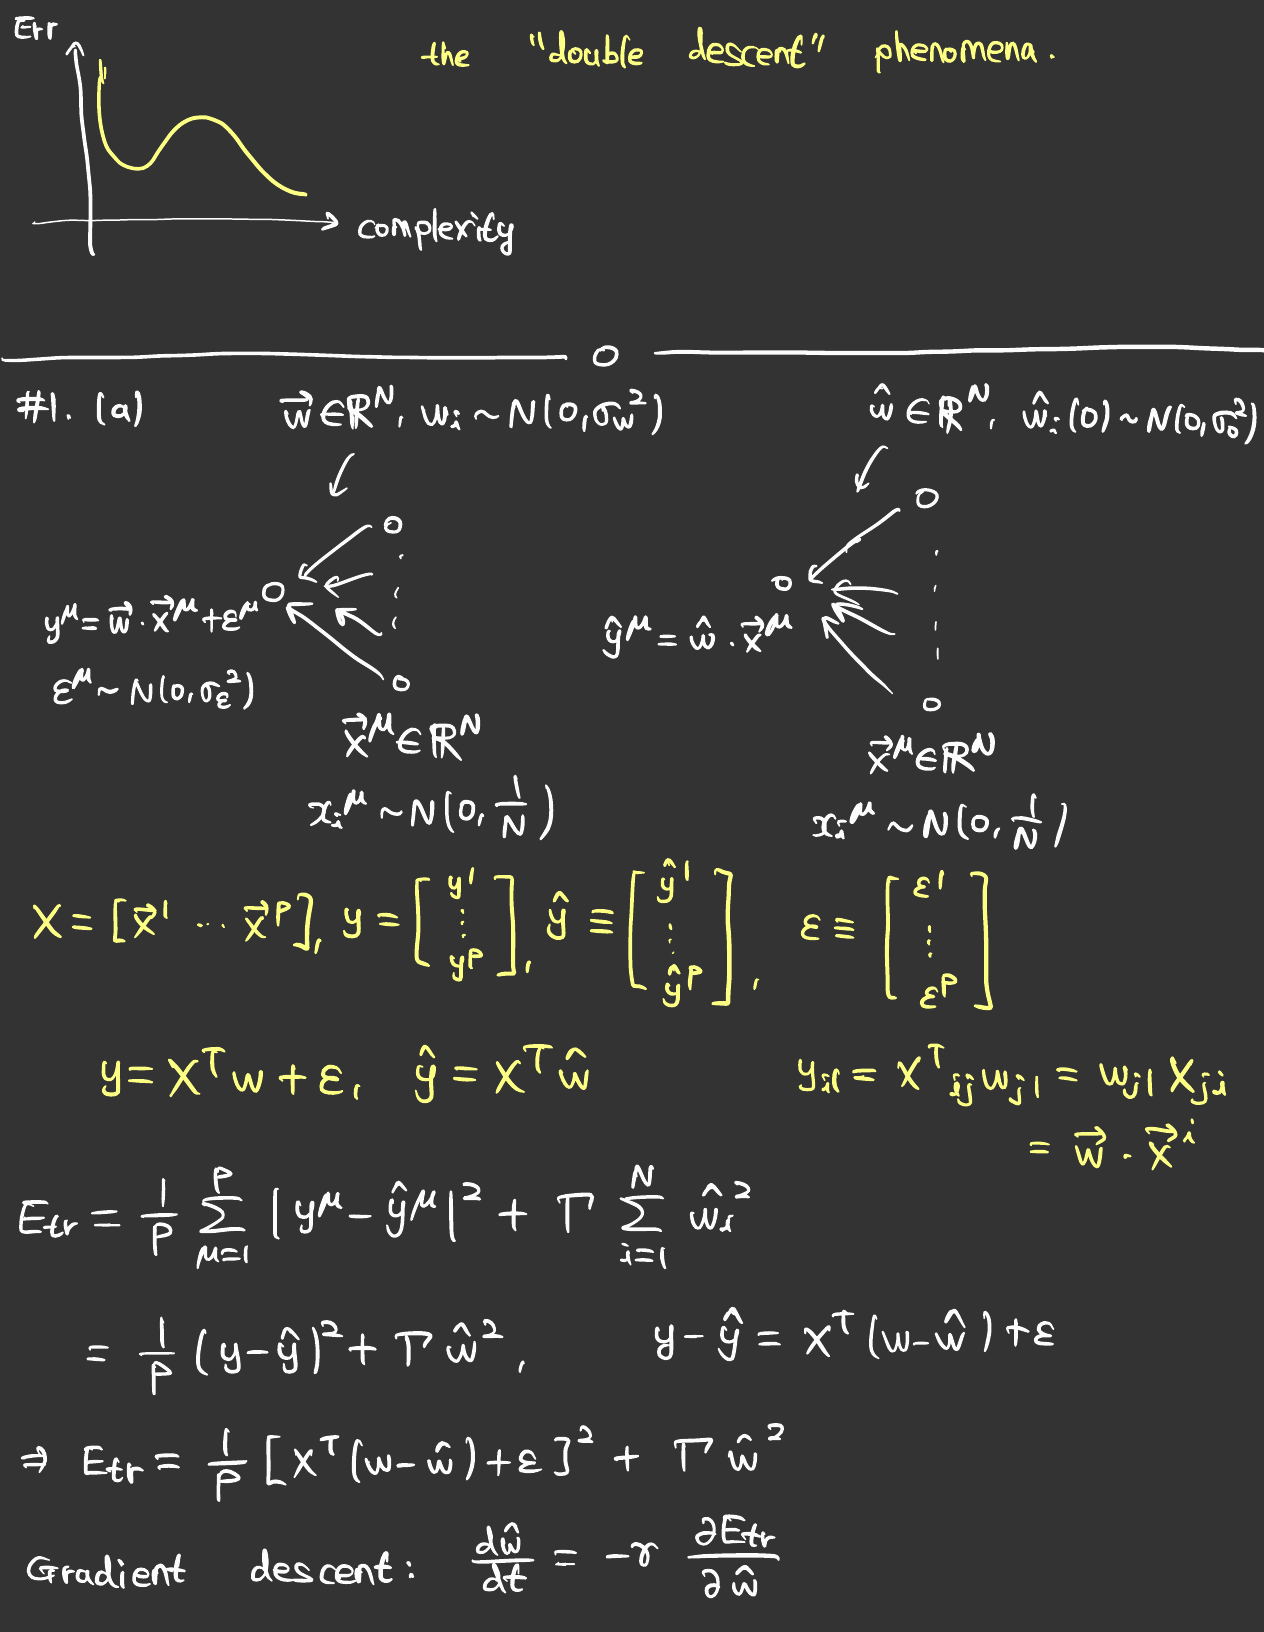

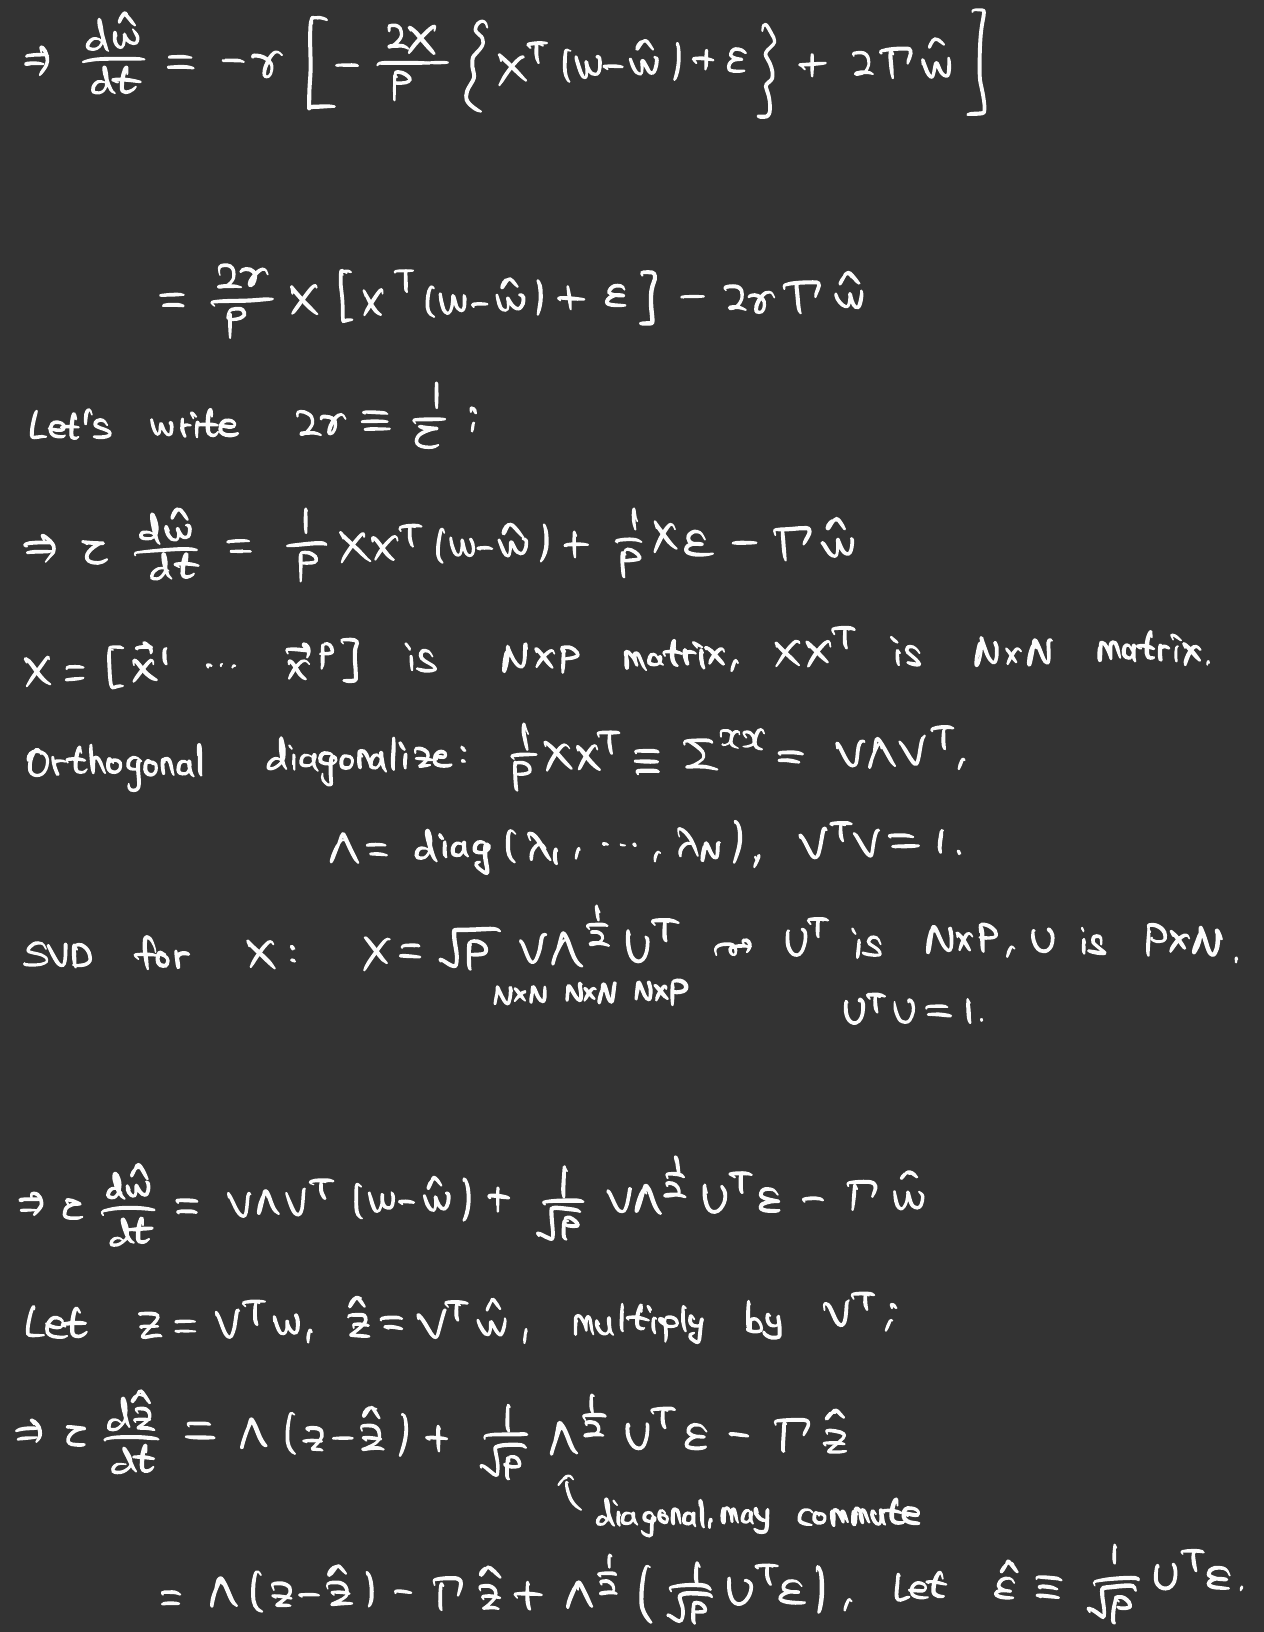

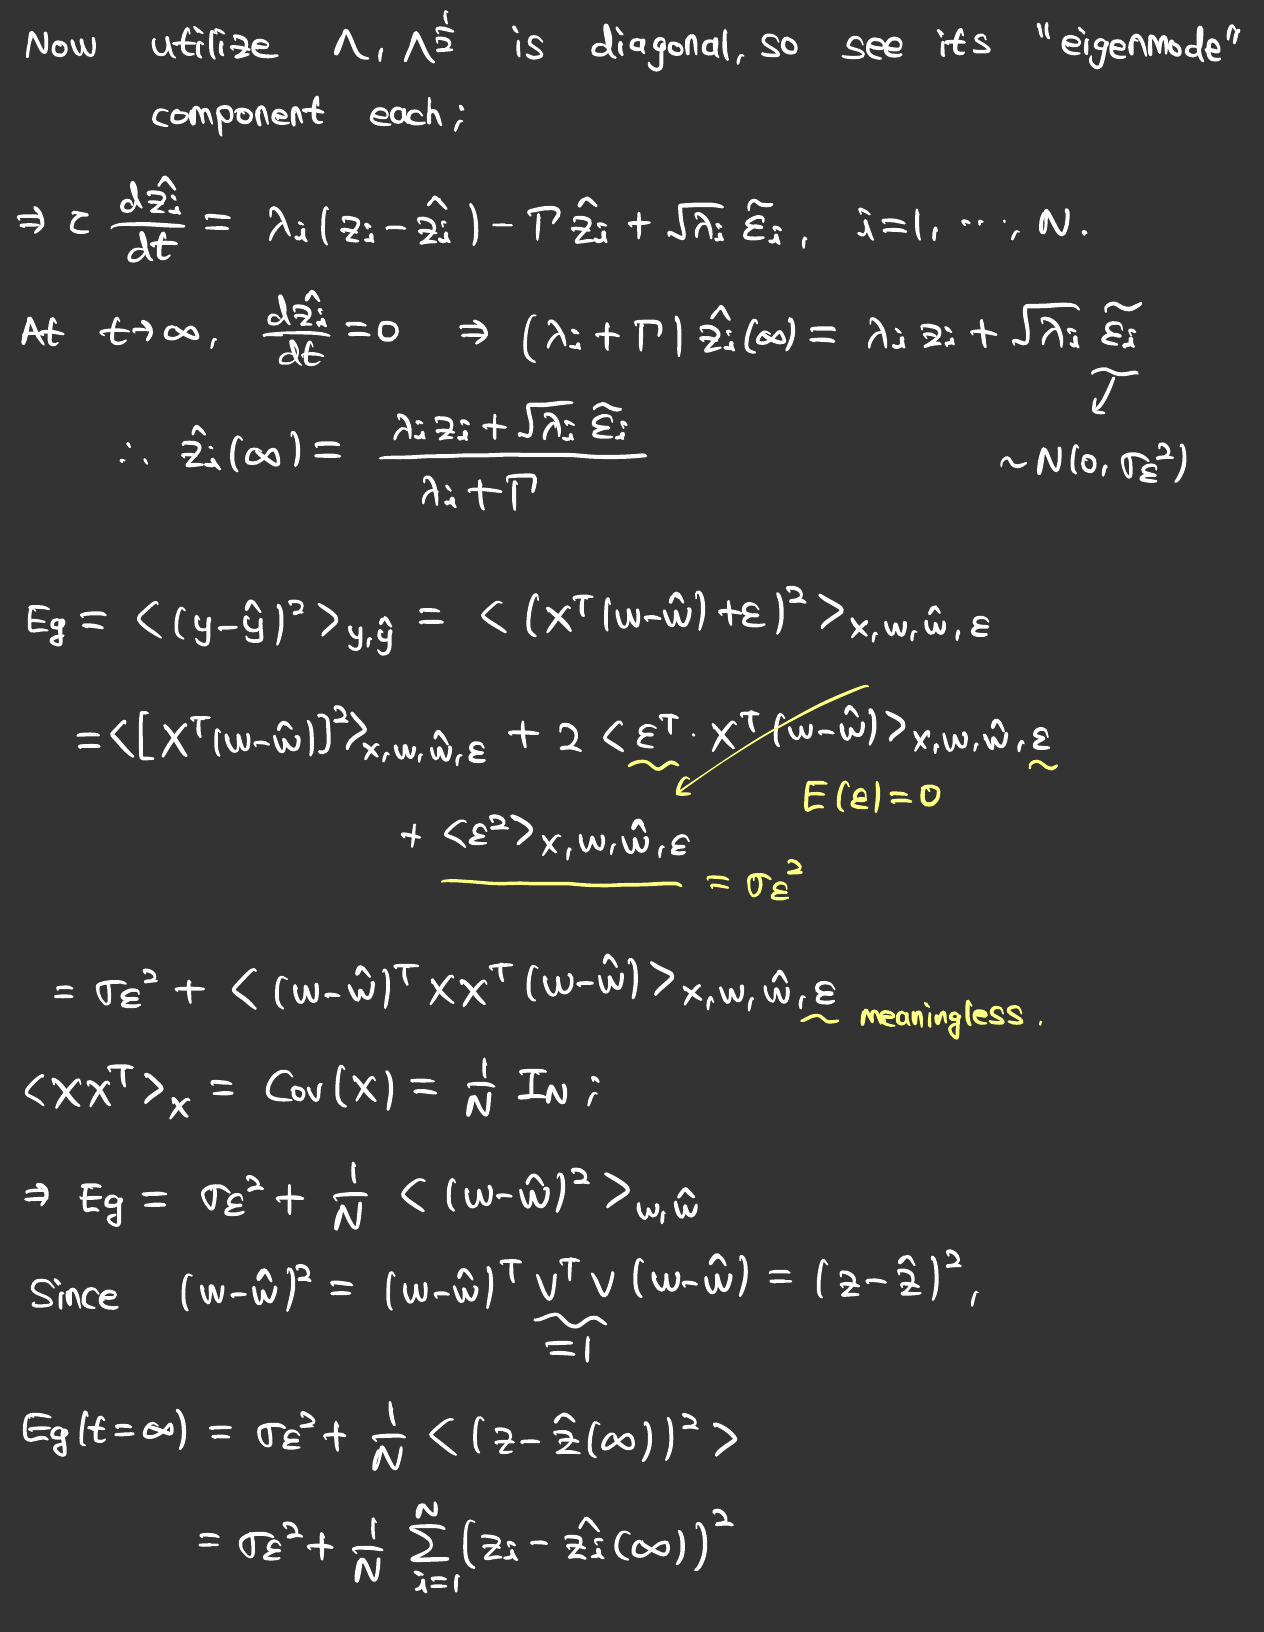

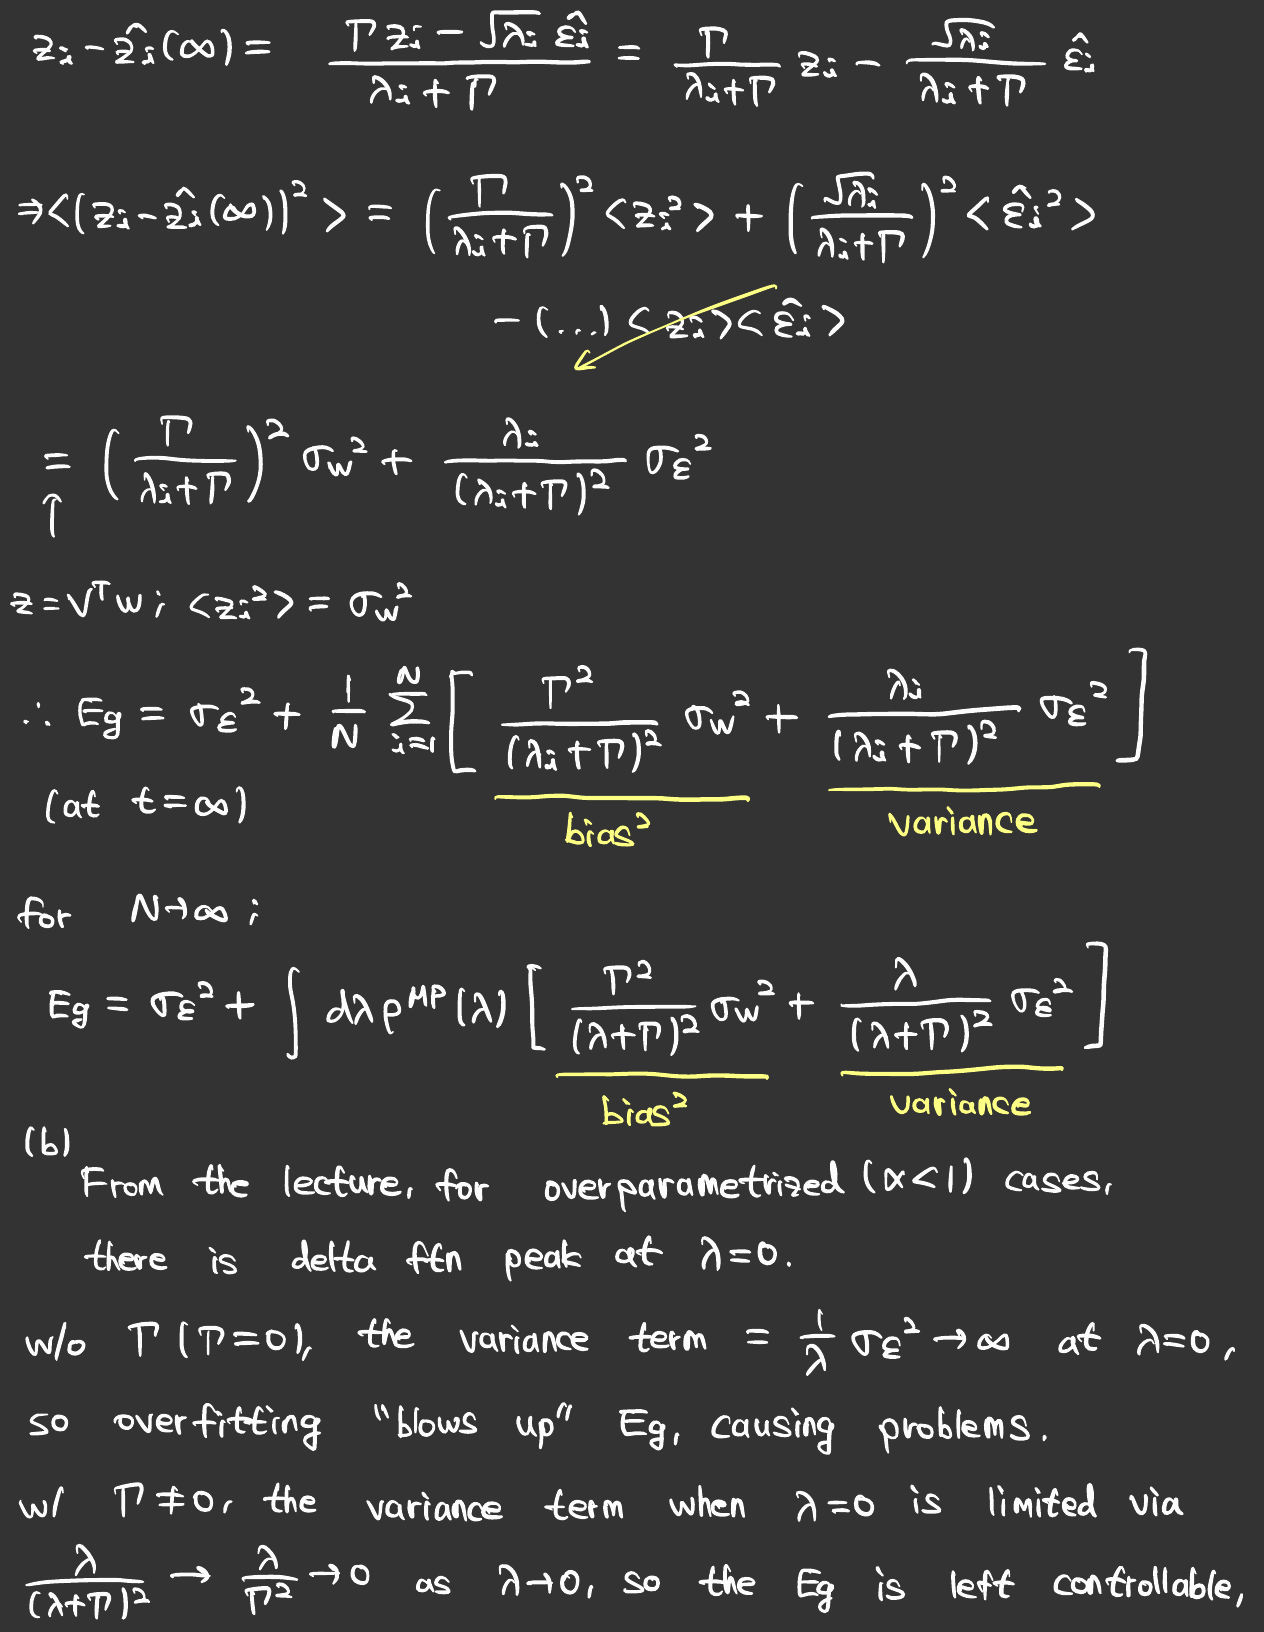

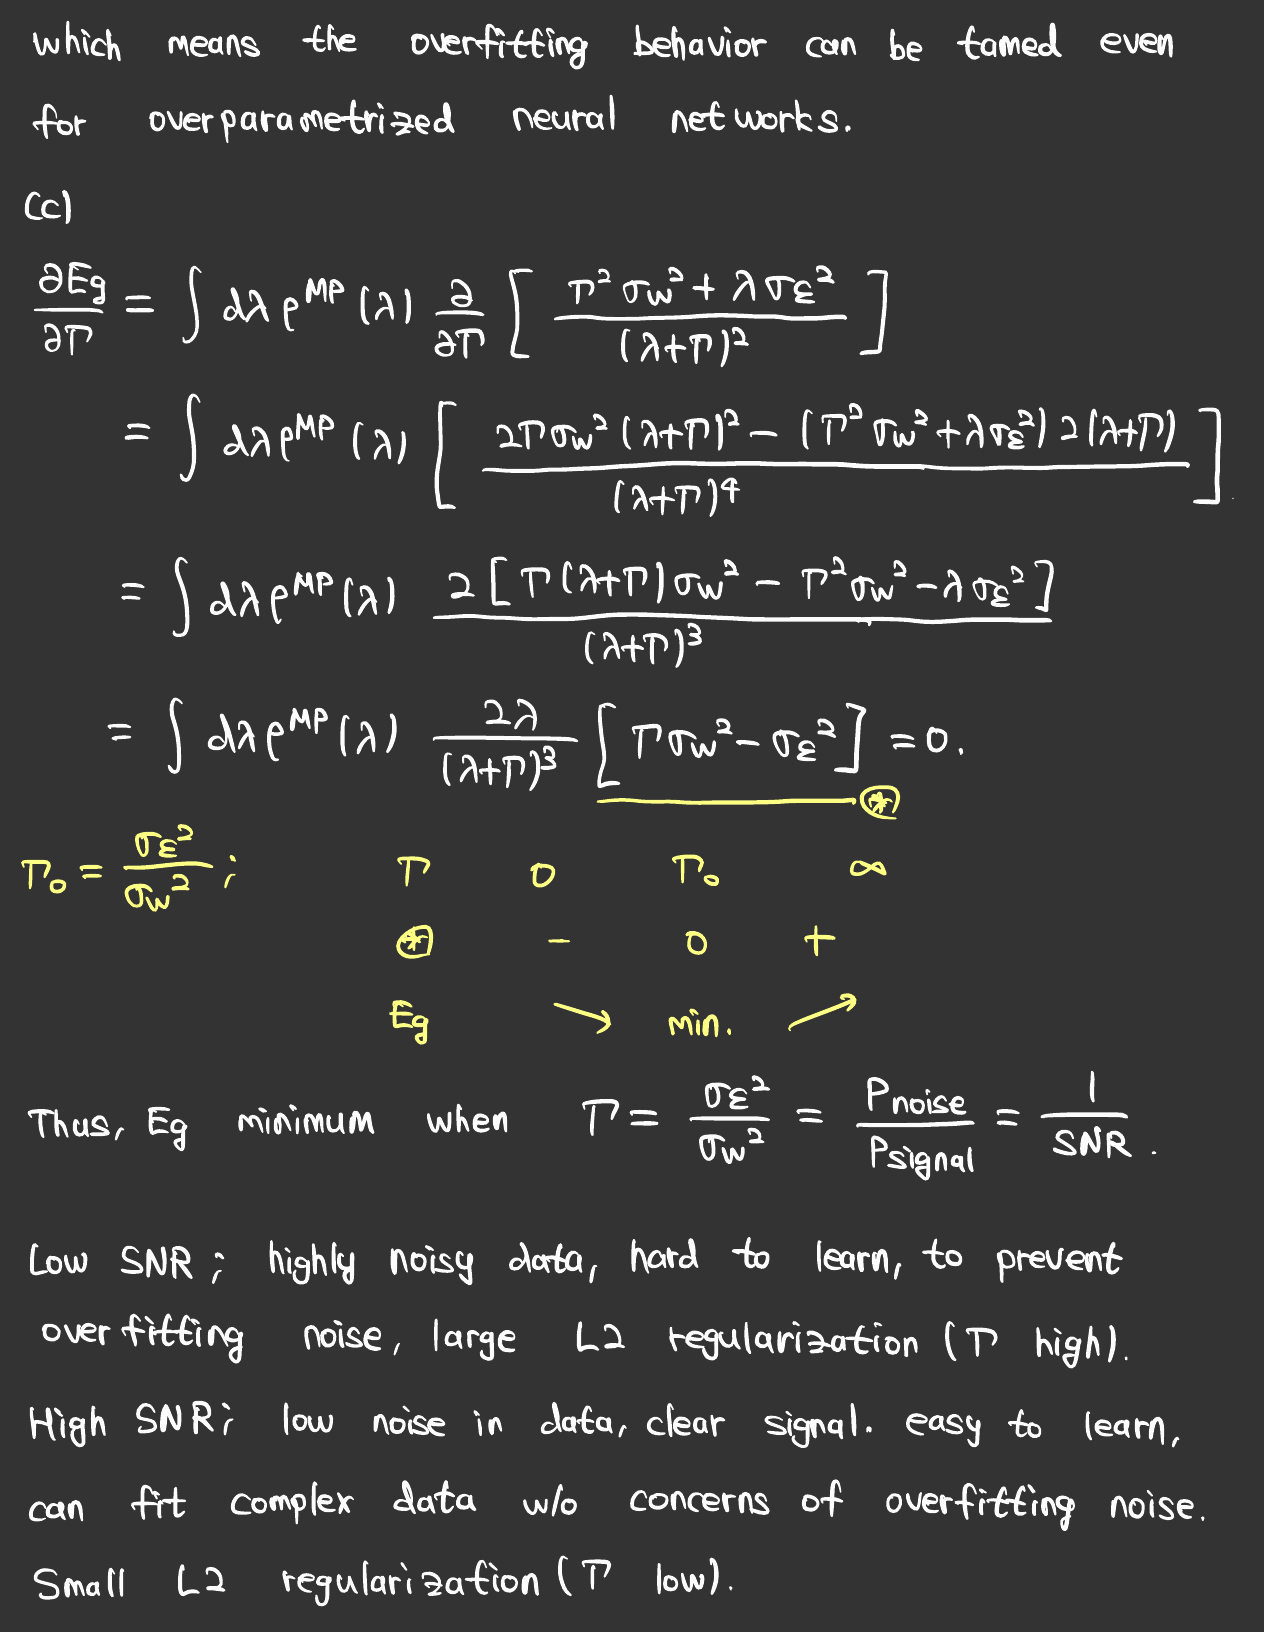

In [ ]:
# for image display in Jupyter Notebook
# don't rerun this cell, as it will overwrite the images
'''
from IPython.display import display, Image

for i in range(5):
    with open(f"{i}.png", "rb") as file:
        display(Image(data=file.read()))
'''

# Problem 2

## Problem (a)

### 1. Load Dataset
Uses the code & dataset provided in class colab files, with slight modification.

In [ ]:
!mkdir -p IsingData
!wget -O IsingData/Ising2DFM_reSample_L40_T=All.pkl https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/Ising2DFM_reSample_L40_T=All.pkl
!wget -O IsingData/Ising2DFM_reSample_L40_T=All_labels.pkl https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/Ising2DFM_reSample_L40_T=All_labels.pkl
# if the link is broken, try:
# !wget -O IsingData/Ising2DFM_reSample_L40_T=All.pkl https://github.com/kimmw3002/CLP_HW1/raw/refs/heads/main/IsingData/Ising2DFM_reSample_L40_T=All.pkl
# !wget -O IsingData/Ising2DFM_reSample_L40_T=All_labels.pkl https://github.com/kimmw3002/CLP_HW1/raw/refs/heads/main/IsingData/Ising2DFM_reSample_L40_T=All_labels.pkl

--2025-05-05 12:56:09--  https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/Ising2DFM_reSample_L40_T=All.pkl
Resolving physics.bu.edu (physics.bu.edu)... 128.197.41.42
Connecting to physics.bu.edu (physics.bu.edu)|128.197.41.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32000161 (31M) [text/plain]
Saving to: ‘IsingData/Ising2DFM_reSample_L40_T=All.pkl’

IsingData/Ising2DFM 100%[===================>]  30.52M  41.0MB/s    in 0.7s    

2025-05-05 12:56:09 (41.0 MB/s) - ‘IsingData/Ising2DFM_reSample_L40_T=All.pkl’ saved [32000161/32000161]

--2025-05-05 12:56:10--  https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/Ising2DFM_reSample_L40_T=All_labels.pkl
Resolving physics.bu.edu (physics.bu.edu)... 128.197.41.42
Connecting to physics.bu.edu (physics.bu.edu)|128.197.41.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1280161 (1.2M) [text/plain]
Saving to: ‘IsingData/Ising2DFM_reSample_L40_T=All_labels.pkl’

IsingData

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class Ising_Dataset(torch.utils.data.Dataset):
    """Ising pytorch dataset."""

    def __init__(self, data_type, transform=False):
        """
        Args:
            data_type (string): `train`, `test` or `critical`: creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.

        """

        L=40 # linear system size
        T=np.linspace(0.25,4.0,16) # temperatures
        T_c=2.26 # critical temperature in the TD limit

        # path to data directory
        path_to_data='IsingData/'

        # load data
        file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
        data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
        data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
        data = data.astype('int')
        data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

        file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
        labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

        # divide data into ordered, critical and disordered

        X_ordered=data[:70000,:]
        Y_ordered=labels[:70000]

        X_critical=data[70000:100000,:]
        Y_critical=labels[70000:100000]

        X_disordered=data[100000:,:]
        Y_disordered=labels[100000:]

        del data,labels
        # define training, critical and test data sets
        X_train=np.concatenate((X_ordered,X_disordered))
        Y_train=np.concatenate((Y_ordered,Y_disordered))

        # here, ordered and disordered data are used for training, critical data is used for testing

        if data_type=='train':
            X=X_train
            Y=Y_train
            print("Training on ordered and disordered examples")

        if data_type=='test':
            X=X_critical
            Y=Y_critical
            print("Testing on %i critical examples"%len(Y_critical))

        # keep the data flattened
        X=X.reshape(X.shape[0], 40 * 40)

        # these are necessary attributes in dataset class and must be assigned
        self.data=(X,Y)
        self.transform = transform


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)

        return sample

def load_data(train_batch_size, test_batch_size):
    train_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='train'),
        batch_size = train_batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='test'),
        batch_size = test_batch_size, shuffle=False)

    return train_loader, test_loader

### 2. Define neural network

In [15]:
class myModel(nn.Module):
    """Simple feedforward neural network."""

    def __init__(self, input_size = 40 * 40, hidden_size = 100, output_size = 2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), # first layer
            nn.ReLU(), # activation function
            nn.Linear(hidden_size, output_size) # second layer
        )

    def forward(self, x):
        x = x.float() # convert to float tensor
        x = self.network(x) # forward pass through the network
        return x

### 3. Train & Testing code

In [16]:
def train_and_test_model(num_epochs = 100, train_batch_size = 512, test_batch_size = 512,
                         hidden_size = 100, learning_rate=1e-3, gamma = 0.0, loss_plot = True):
    train_loader, test_loader = load_data(train_batch_size, test_batch_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device)

    model = myModel(hidden_size = hidden_size).to(device) # create model and move to device (GPU or CPU)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = gamma)
    # SGD optimizer with L2 regularization (weight decay)
    loss_module = nn.CrossEntropyLoss() # loss function for classification

    train_losses = []
    test_losses = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0

        for data, label in train_loader:
            data, label = data.to(device), label.to(device)

            loss = loss_module(model(data), label) # compute loss
            train_loss += loss.item() # accumulate loss

            optimizer.zero_grad() # zero the gradients
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader.dataset) # average loss over the dataset
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)

                loss = loss_module(model(data), label)
                test_loss += loss.item() # accumulate loss

        test_loss /= len(test_loader.dataset) # average loss over the dataset
        test_losses.append(test_loss)

    if loss_plot:
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return train_losses, test_losses

### 4. Run Code

Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 200/200 [05:49<00:00,  1.75s/it]


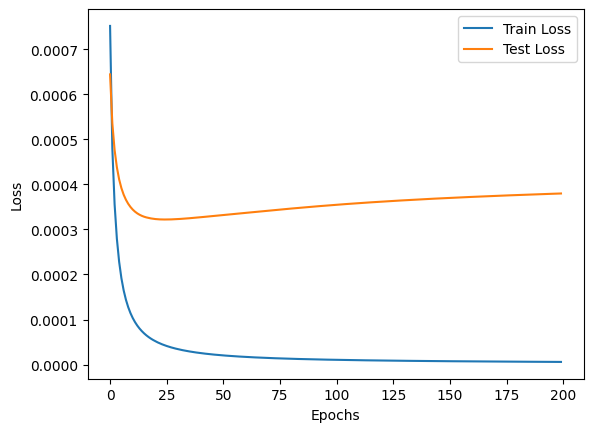

In [17]:
torch.manual_seed(0) # for reproducibility
_ = train_and_test_model(num_epochs = 200)

As training continues, the train loss decreases, but the test loss decreases only at the beginning of the training and starts to increase from around the 20th epoch. This change of trend is clearly a sign of overfitting.

## Problem (b)

### 1. Generate train loss data for various hidden layer size

In [18]:
hidden_sizes = [20, 40, 80, 160, 320] # different hidden layer sizes
final_test_losses = []

for hidden_size in hidden_sizes:
    print(f"Training with hidden size: {hidden_size}")
    train_losses, test_losses = train_and_test_model(num_epochs=100, hidden_size=hidden_size, loss_plot = False)
    final_test_loss = test_losses[-1]
    final_test_losses.append(final_test_loss)

Training with hidden size: 20
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Training with hidden size: 40
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


Training with hidden size: 80
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


Training with hidden size: 160
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


Training with hidden size: 320
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


### 2. Interpret Result

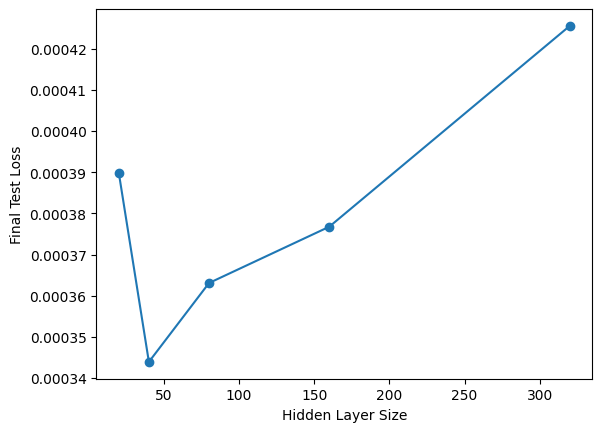

In [19]:
plt.plot(hidden_sizes, final_test_losses, marker='o')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Final Test Loss')
plt.show()

As we increase the hidden layer size, at first the final test loss decreases, but as the model gets highly complex, the final test loss starts to climb rather than decreasing monotonically. This U-shaped curve is a signal of:
- For small hidden layer size, the model underfits, so as we increase parameters, the model learns better, decreasing final test loss.
- For large hidden layer size, the model overfits since there are too many parameters. The overfitting causes final test loss to increase as the model gets more complex.

## Problem (c)

### 1. Redo (a)

Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 200/200 [05:52<00:00,  1.76s/it]


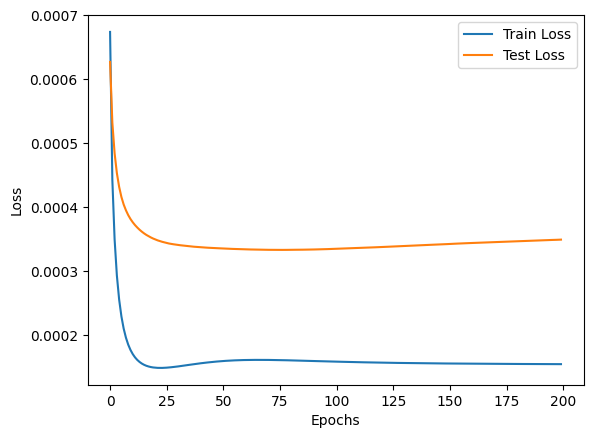

In [20]:
_ = train_and_test_model(num_epochs = 200, gamma = 0.1)

We see that after the test loss hits its minimum, the climb of the test loss due to overfitting has a much smaller slope. The curve after the minimum test loss is more "squashed". This suggests the L2 regularization term hampers the overfitting process.

### 2. Redo (b)

Training with hidden size: 20
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


Training with hidden size: 40
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Training with hidden size: 80
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


Training with hidden size: 160
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


Training with hidden size: 320
Training on ordered and disordered examples
Testing on 30000 critical examples
Using device:  cuda


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


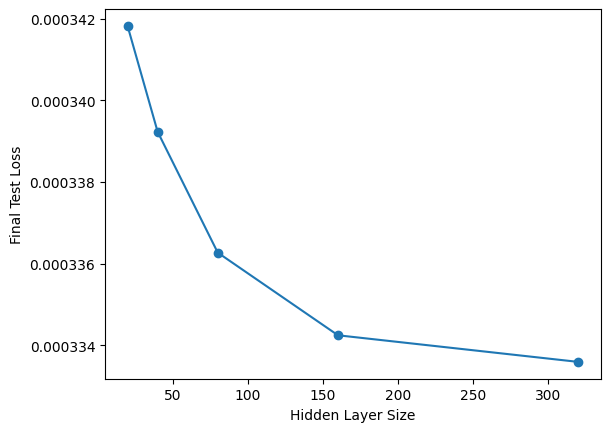

In [21]:
hidden_sizes = [20, 40, 80, 160, 320] # different hidden layer sizes
l2_reg_final_test_losses = []

for hidden_size in hidden_sizes:
    print(f"Training with hidden size: {hidden_size}")
    train_losses, test_losses = train_and_test_model(gamma = 0.1, num_epochs=100, hidden_size=hidden_size, loss_plot = False)
    final_test_loss = test_losses[-1]
    l2_reg_final_test_losses.append(final_test_loss)

plt.plot(hidden_sizes, l2_reg_final_test_losses, marker='o')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Final Test Loss')
plt.show()

Unlike the first result without L2 regularization, the final test loss now monotonically decreases as we increase the hidden layer size. Since L2 regulariztion prevents the model overfitting, a more complex model now learns better than a less complex model without overfitting the training dataset.

# Problem 3

## Problem (a)

### 1. Download(Generate) dynamics dataset

In [ ]:
# simulating a 1D CLG model ensemble takes a long time
# so will use a pre-computed ensemble of runs
# done on my local machine, which can be downloaded via:
!wget -O clg_finals_dynamics_10000samples.npy https://github.com/kimmw3002/CLP_HW1/raw/refs/heads/main/clg_finals_dynamics_10000samples.npy

--2025-05-07 11:55:37--  https://github.com/kimmw3002/CLP_HW1/raw/refs/heads/main/clg_finals_dynamics_10000samples.npy
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kimmw3002/CLP_HW1/refs/heads/main/clg_finals_dynamics_10000samples.npy [following]
--2025-05-07 11:55:38--  https://raw.githubusercontent.com/kimmw3002/CLP_HW1/refs/heads/main/clg_finals_dynamics_10000samples.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100000128 (95M) [application/octet-stream]
Saving to: ‘clg_finals_dynamics_10000samples.npy’

clg_finals_dynamics 100%[===================>]  95.37M   363MB/s    in 0.3s 

In [ ]:
# clg.py
# on windows, make this a separate .py file to avoid issues with multiprocessing
# can be run directly as a cell in colab

# simulating a 1D CLG model ensemble takes a long time
# so will use a pre-computed ensemble of runs
# done on my local machine, which can be downloaded from the cell above
# in theory, you could run this to generate the ensemble on colab
import numpy as np
import warnings
from concurrent.futures import ProcessPoolExecutor

# ---------- single‑run simulator ----------
def run_CLG_until_absorbing(L, N, max_steps=1_000_000, rng=None):
    rng = rng or np.random.default_rng()
    conf = np.zeros(L, dtype=np.int8)
    conf[rng.choice(L, N, replace=False)] = 1

    for _ in range(max_steps):
        occ = conf == 1
        left_occ   = np.roll(occ,  1)
        right_occ  = np.roll(occ, -1)
        left_emp   = np.roll(conf,  1) == 0
        right_emp  = np.roll(conf, -1) == 0
        movable = np.where(occ & (left_occ | right_occ) & (left_emp | right_emp))[0]
        if movable.size == 0:
            return conf
        i = rng.choice(movable)
        targets = [(i - 1) % L] if left_emp[i] else []
        if right_emp[i]:
            targets.append((i + 1) % L)
        j = rng.choice(targets)
        conf[j], conf[i] = 1, 0
    warnings.warn("max_steps reached before absorbing", RuntimeWarning)
    return conf

# ---------- helper for the pool ----------
def _worker(args):
    L, N, max_steps, seed = args
    return run_CLG_until_absorbing(L, N, max_steps, rng=np.random.default_rng(seed))

# ---------- public ensemble ----------
def run_ensemble_cpu(L, N, runs, max_steps=1_000_000, n_workers=None, seed=None):
    master = np.random.default_rng(seed)
    seeds  = master.integers(0, 2**63 - 1, size=runs)
    args   = [(L, N, max_steps, s) for s in seeds]
    with ProcessPoolExecutor(max_workers=n_workers) as pool:
        finals = list(pool.map(_worker, args, chunksize=1))
    return np.array(finals)            # shape (runs, L)

# ---------- run the ensemble ----------
if __name__ == "__main__":
    L, rho, R = 10_000, 0.4, 10000    # lattice, density, #runs
    finals = run_ensemble_cpu(L, int(L*rho), R, n_workers=None, seed=42)
    np.save("clg_finals_dynamics_10000samples.npy", finals)
    print("CPU ensemble done & saved.")

### 2. Generate combinatorics dataset

In [ ]:
import numpy as np

def run_dataset2_fast(L, N, C):
    """
    Returns a (C, L) array of 0/1 rows, each with N ones and no two 1s adjacent.
    """
    M = L - N + 1
    # 1) pick N “slots” in [0..M-1] per row
    rand = np.random.rand(C, M)
    idxs = np.argpartition(rand, N-1, axis=1)[:, :N]
    idxs.sort(axis=1)

    # 2) shift so no two 1’s touch
    offsets   = np.arange(N)
    positions = idxs + offsets  # (C, N)

    # 3) scatter into zero array
    data = np.zeros((C, L), dtype=np.int8)
    rows = np.arange(C)[:, None]
    data[rows, positions] = 1

    return data

L, N, C = 10000, 4000, 10000   # parameters for the dataset
data = run_dataset2_fast(L, N, C)
# save to .npy
np.save("clg_finals_combinatorics_10000samples.npy", data)
print(f"Saved to clg_finals_combinatorics_10000samples.npy")

Saved to clg_finals_combinatorics_10000samples.npy


## Problem (b)

In [ ]:
import numpy as np
import zlib

def compress_lza(data_bytes):
    """
    Placeholder LZ77-based compressor wrapper.
    Currently uses zlib (DEFLATE) for fast C-based compression.
    Returns compressed byte-length.
    """
    return len(zlib.compress(data_bytes))

def compute_cid_stats(dataset, compressor):
    """
    Returns (mean_cid, std_cid) for CID = compressed_length / original_length
    computed over each row of `dataset` (shape (C, L)).
    """
    C, L = dataset.shape
    cids = np.empty(C, dtype=float)
    for i in range(C):
        row_bytes   = dataset[i].astype(np.uint8).tobytes()
        compressed  = compressor(row_bytes)
        cids[i]     = compressed / len(row_bytes)
    return cids.mean(), cids.std()

dyn_file  = "clg_finals_dynamics_10000samples.npy"
comb_file = "clg_finals_combinatorics_10000samples.npy"

# load datasets
dynamics      = np.load(dyn_file)
combinatorics = np.load(comb_file)

# compute mean and standard deviation of CID
mean_dyn,  std_dyn  = compute_cid_stats(dynamics,      compress_lza)
mean_comb, std_comb = compute_cid_stats(combinatorics, compress_lza)

print(f"Dynamics CID:      mean = {mean_dyn:.6f}, std = {std_dyn:.6f}")
print(f"Combinatorics CID: mean = {mean_comb:.6f}, std = {std_comb:.6f}")

Dynamics CID:      mean = 0.095458, std = 0.001225
Combinatorics CID: mean = 0.106414, std = 0.000825


1. **Standard error of each mean**

   $$
   \mathrm{SE}_1 = \frac{\sigma_1}{\sqrt{N_1}}
     = \frac{0.001225}{\sqrt{10000}}
     = 1.225\times10^{-5},
   \quad
   \mathrm{SE}_2 = \frac{\sigma_2}{\sqrt{N_2}}
     = \frac{0.000825}{\sqrt{10000}}
     = 8.25\times10^{-6}.
   $$

2. **Standard error of the difference**

   $$
   \mathrm{SE}_\Delta
     = \sqrt{\mathrm{SE}_1^2 + \mathrm{SE}_2^2}
     = \sqrt{(1.225\times10^{-5})^2 + (8.25\times10^{-6})^2}
     \approx 1.477\times10^{-5}.
   $$

3. **Difference of means**

   $$
   \Delta \mu
     = \bar x_2 - \bar x_1
     = 0.106414 - 0.095458
     = 0.010956.
   $$

4. **Z-score**

   $$
   z
     = \frac{\Delta \mu}{\mathrm{SE}_\Delta}
     = \frac{0.010956}{1.477\times10^{-5}}
     \approx 741.8.
   $$

5. **Two-sided \(p\)-value**

   $$
   p
     = 2\,(1 - \Phi(z))
     \approx 0.
   $$

---

**Conclusion:**  
The difference remains hundreds of standard errors apart—overwhelmingly significant. This proves that the dynamically reached ensemble is different from the combinatorics based ensemble generation. The dynamically reached states are not a uniform probability ensemble of all combinatorically possible states.

## Problem (c)

We change the hyperparameter `n_blocks` to test the performance of the 1d CNN. One "block" is composed with `Conv1d` + `ReLU` + `MaxPool1d`. For the first block, the number of channels is selected as 16, and for each another block, the number of channel doubles. Other hyperparameters are the most typically used ones.

In [ ]:
"""
Full, self-contained script to compare 1, 2, 3 convolutional “blocks”.

A *block* = Conv1d(kernel_size =3, stride = 1, padding = 1)
         → ReLU
         → MaxPool1d(kernel_size = 2, stride = 2, padding = 0)

Conv channel width doubles after every block.
After n_blocks pools the 1-D length shrinks to  L // (2**n_blocks).

The first Linear therefore needs:
    flat_dim = (base_ch * 2**(n_blocks-1)) * (L // 2**n_blocks)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ───────────────────────────────── hyper‑params ──────────────────────────────
L           = 10_000          # input sequence length
base_ch     = 16              # channels of the first conv
batch_size  = 64
epochs      = 10
lr          = 1e-3
block_list  = (1, 2, 3)       # experiment sweep
# ───────────────────────────────── reproducibility ────────────────────────────
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
# ───────────────────────────────────── model ──────────────────────────────────
class CLGModel(nn.Module):
    def __init__(self, L: int, n_blocks: int, base_ch: int = 16):
        super().__init__()

        layers = []
        in_ch, out_ch = 1, base_ch

        for _ in range(n_blocks):
            layers.extend([
                nn.Conv1d(in_channels=in_ch,
                          out_channels=out_ch,
                          kernel_size=3,  # explicit
                          stride=1,       # explicit
                          padding=1),     # explicit
                nn.ReLU(inplace=True),
                nn.MaxPool1d(kernel_size=2,  # explicit
                             stride=2,       # explicit
                             padding=0)      # explicit
            ])
            in_ch, out_ch = out_ch, out_ch * 2  # double channels

        self.conv = nn.Sequential(*layers)

        seq_len_after = L // (2 ** n_blocks)
        channels_after = base_ch * (2 ** (n_blocks - 1))
        flat_dim = channels_after * seq_len_after

        self.cls = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)              # raw logits for CrossEntropyLoss
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)       # (B,1,L)
        x = self.conv(x)
        return self.cls(x)

# ───────────────────────────────────── data ───────────────────────────────────
dynamics       = np.load("clg_finals_dynamics_10000samples.npy")
combinatorics  = np.load("clg_finals_combinatorics_10000samples.npy")

X = np.concatenate((dynamics, combinatorics), axis=0)
y = np.concatenate((np.zeros(len(dynamics)), np.ones(len(combinatorics))), axis=0)

indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

train_end = int(0.8 * len(X))
val_end   = int(0.9 * len(X))

X_train, y_train = X[:train_end],          y[:train_end]
X_val,   y_val   = X[train_end:val_end],   y[train_end:val_end]
X_test,  y_test  = X[val_end:],            y[val_end:]

def to_loader(Xn, yn, shuffle=False):
    X_t = torch.from_numpy(Xn).float()
    y_t = torch.from_numpy(yn).long()
    ds  = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

train_loader = to_loader(X_train, y_train, shuffle=True)
val_loader   = to_loader(X_val,   y_val)
test_loader  = to_loader(X_test,  y_test)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# ────────────────────────────── helpers ───────────────────────────────────────
def train_one_epoch(model, loader, optimizer):
    model.train()
    running = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def accuracy(model, loader):
    model.eval()
    correct = tot = 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        correct += (model(xb).argmax(1) == yb).sum().item()
        tot     += yb.size(0)
    return correct / tot

# ───────────────────────────── experiment loop ───────────────────────────────
for n_blocks in block_list:
    model = CLGModel(L=L, n_blocks=n_blocks, base_ch=base_ch).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    print(f"\n─── {n_blocks} BLOCK{'S' if n_blocks>1 else ''} ─────────────────────")
    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer)
        val_acc = accuracy(model, val_loader)
        print(f"Epoch {epoch:2d} | Train Loss {tr_loss:.4f} | Val Acc {val_acc:.4f}")

    tst_acc = accuracy(model, test_loader)
    print(f"Test Accuracy: {tst_acc:.4f}")



─── 1 BLOCK ─────────────────────
Epoch  1 | Train Loss 1.0421 | Val Acc 0.4975
Epoch  2 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  3 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  4 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  5 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  6 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  7 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  8 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  9 | Train Loss 0.6932 | Val Acc 0.4975
Epoch 10 | Train Loss 0.6932 | Val Acc 0.4975
Test Accuracy: 0.4855

─── 2 BLOCKS ─────────────────────
Epoch  1 | Train Loss 0.8416 | Val Acc 0.4975
Epoch  2 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  3 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  4 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  5 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  6 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  7 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  8 | Train Loss 0.6932 | Val Acc 0.4975
Epoch  9 | Train Loss 0.6932 | Val Acc 0.4975
Epoch 10 | Train Loss 0.6932 | Va

The result is surprising: for `n_blocks` value 1 or 2, the model struggles to learn - the accuracy is close to 50%, which suggests the model is nearly random guessing. But for `n_blocks` value 3, the model suddenly classifies the two datasets to a perfect level! This suggests that the characteristic difference of the two datasets is "long-ranged" so at least 3 blocks of convolution + max pooling is required to extract the feature that discriminates the two datasets.